In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#import keras
#import sklearn
#import torch
#import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge
from pandas_profiling import ProfileReport

In [4]:
%matplotlib inline

In [3]:
col_types = {'Store': str,
             'Date':str,
             'Weekly_Sales':np.float64,
             'Holiday_Flag':np.float16,
             'Temperature':np.float16,
             'Fuel_Price':np.float16,
             'CPI':np.float16,
            'Unemployment':np.float16,}
data = pd.read_csv('./../data/raw/Walmart_Store_sales.csv', date_parser=True)#, usecols=col_types.keys(), dtype=col_types)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


Initially, the dataset has 7 numerical variables and 1 categorical.  The Store and holiday flag is kind of a categorical feature

## <b> Count missing values

In [5]:
def missing_values(data):
    return pd.concat([data.isna().sum(), 
        np.round(data.isna().sum()*100/data.shape[0])], 
        axis=1).rename({0:'count_missing', 1:'%_missing'}, axis=1)

In [6]:
missing_values(data)

,count_missing,%_missing
Store,0,0.0
Date,18,12.0
Weekly_Sales,14,9.0
Holiday_Flag,12,8.0
Temperature,18,12.0
Fuel_Price,14,9.0
CPI,12,8.0
Unemployment,15,10.0


In [8]:
data = data.dropna(subset=['Weekly_Sales', 'Date'], axis=0)

In [9]:
missing_values(data)

,count_missing,%_missing
Store,0,0.0
Date,0,0.0
Weekly_Sales,0,0.0
Holiday_Flag,9,8.0
Temperature,11,9.0
Fuel_Price,11,9.0
CPI,9,8.0
Unemployment,11,9.0


In [7]:
data

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
...,...,...,...,...,...,...,...,...
145,14.0,18-06-2010,2248645.59,0.0,72.62,2.780,182.442420,8.899
146,7.0,NaN,716388.81,NaN,20.74,2.778,NaN,NaN
147,17.0,11-06-2010,845252.21,0.0,57.14,2.841,126.111903,NaN
148,8.0,12-08-2011,856796.10,0.0,86.05,3.638,219.007525,NaN


In [10]:
data['Date']=pd.to_datetime(data['Date']).dt.date
data.head()

/home/carmina/miniconda3/envs/pez-jedha/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470
4,6.0,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092
5,4.0,2010-05-28,1857533.70,0.0,NaN,2.756,126.160226,7.896
6,15.0,2011-03-06,695396.19,0.0,69.80,4.069,134.855161,7.658


## <b> Some data cleaning

In [11]:
data.iloc[: ,:-2].describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price
count,118.000000,1.180000e+02,109.000000,107.000000,107.000000
mean,9.949153,1.257271e+06,0.073394,60.711589,3.291542
std,6.066367,6.625056e+05,0.261987,17.961676,0.486784
min,1.000000,2.689290e+05,0.000000,18.790000,2.514000
25%,4.250000,5.774276e+05,0.000000,45.465000,2.824000
50%,9.000000,1.331001e+06,0.000000,61.790000,3.308000
75%,15.000000,1.810591e+06,0.000000,75.430000,3.691500
max,20.000000,2.771397e+06,1.000000,91.650000,4.193000


In [269]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 0 to 149
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         118 non-null    object 
 1   Date          118 non-null    object 
 2   Weekly_Sales  118 non-null    float64
 3   Holiday_Flag  109 non-null    float64
 4   Temperature   107 non-null    float64
 5   Fuel_Price    107 non-null    float64
 6   CPI           109 non-null    float64
 7   Unemployment  107 non-null    float64
 8   Year          118 non-null    float64
 9   Month         118 non-null    float64
 10  dayOfWeek     118 non-null    float64
 11  weekday       118 non-null    object 
 12  week          118 non-null    UInt32 
dtypes: UInt32(1), float64(9), object(3)
memory usage: 12.6+ KB


In [19]:
profile = ProfileReport(data, title="Pandas Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
#data['Date2']=pd.to_datetime(data['Date']).dt.date

data['Year']=pd.to_datetime(data['Date']).dt.year #Because of null values, year could be float, so casting is used to force it to int.
data['Month']=pd.to_datetime(data['Date']).dt.month.astype(np.int8)
data['dayOfWeek']=pd.to_datetime(data['Date']).dt.dayofweek.astype(np.int8)
data['weekday']=pd.to_datetime(data['Date']).dt.strftime("%A")
data['week']=pd.to_datetime(data['Date']).dt.isocalendar().week.astype(np.int8)
data['Store'] = data['Store'].astype('str')
data.sort_values(by=['Date','Month']).head(10)

/home/carmina/miniconda3/envs/pez-jedha/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,dayOfWeek,weekday,week
14,17.0,2010-01-10,829207.27,0.0,60.07,2.853,126.234600,6.885,2010,1,6,Sunday,1
20,7.0,2010-02-04,561145.14,0.0,38.26,2.725,189.704822,8.963,2010,2,3,Thursday,5
47,19.0,2010-02-07,1549018.68,0.0,66.25,2.958,132.521867,8.099,2010,2,6,Sunday,5
99,13.0,2010-02-07,2018314.71,0.0,78.82,2.814,126.139200,7.951,2010,2,6,Sunday,5
112,2.0,2010-02-19,2124451.54,0.0,39.69,2.514,210.945160,NaN,2010,2,4,Friday,7
115,15.0,2010-02-19,660838.75,0.0,NaN,2.909,131.637000,NaN,2010,2,4,Friday,7
106,14.0,2010-02-26,2095591.63,0.0,34.89,NaN,NaN,8.992,2010,2,4,Friday,8
23,19.0,2010-03-26,1427023.45,0.0,39.07,2.963,131.863129,8.350,2010,3,4,Friday,12
143,3.0,2010-04-06,396968.80,0.0,78.53,2.705,214.495838,7.343,2010,4,1,Tuesday,14
28,17.0,2010-04-16,757738.76,0.0,45.22,2.915,126.562100,6.635,2010,4,4,Friday,15


## Check weeks with holidays

In [122]:
data[data['Holiday_Flag']==1][['Store','Date','Year','Month', 'week']].sort_values('Date')

,Store,Date,Year,Month,week
135,12.0,2010-10-09,2010,10,40
114,11.0,2010-11-26,2010,11,47
44,1.0,2010-12-02,2010,12,48
107,8.0,2010-12-02,2010,12,48
110,20.0,2010-12-31,2010,12,52
122,7.0,2012-07-09,2012,7,28
32,7.0,2012-10-02,2012,10,40
33,14.0,2012-10-02,2012,10,40


In [13]:
holiday_weeks = data[data['Holiday_Flag']==1].week.to_list()
del holiday_weeks[2]
holiday_weeks = np.unique(holiday_weeks)
print(f'Weeks with holidays: {holiday_weeks}')

Weeks with holidays: [28 40 47 48 52]


## <b> Sales per Store

Index(['14.0', '13.0', '4.0', '1.0', '2.0', '19.0', '6.0', '18.0', '20.0',
       '10.0', '8.0', '12.0', '17.0', '3.0', '7.0', '16.0', '5.0', '9.0',
       '15.0', '11.0'],
      dtype='object', name='Store')

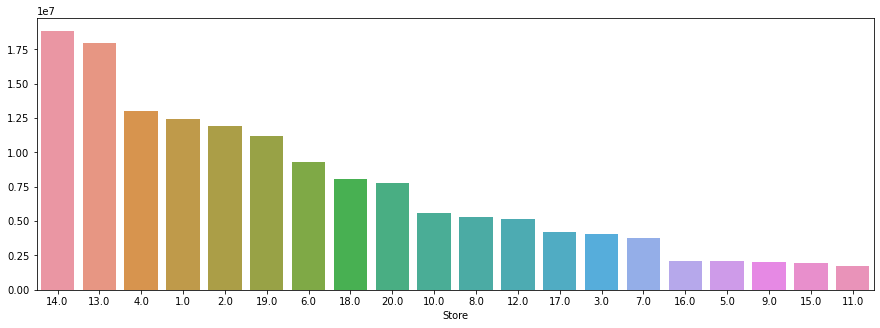

In [14]:
sales_per_store = data.groupby('Store').Weekly_Sales.sum().sort_values(ascending=False)
sales_per_store
plt.figure(figsize=(15, 5))
sns.barplot(x=sales_per_store.index, y=sales_per_store.values)
sales_per_store.index

### The stores 14, 13, 2, 1, 4 have the top sales

In [15]:
def sales_per_month(data):
    sales_month = data.groupby('Month')['Weekly_Sales'].agg('sum')
    return sales_month

#data['Date2']=pd.to_datetime(data['Date']).dt.date

data['Year']=pd.to_datetime(data['Date']).dt.year.astype('Int16') #Because of null values, year could be float, so casting is used to force it to int.
data['Month']=pd.to_datetime(data['Date']).dt.month.astype('Int16')
data['dayOfWeek']=pd.to_datetime(data['Date']).dt.dayofweek.astype('Int16')
data['weekday']=pd.to_datetime(data['Date']).dt.strftime("%A")
data['week']=pd.to_datetime(data['Date']).dt.isocalendar().week
data.sort_values(by=['Date','Month']).head(10)

## Sales per month

<AxesSubplot:xlabel='Month'>

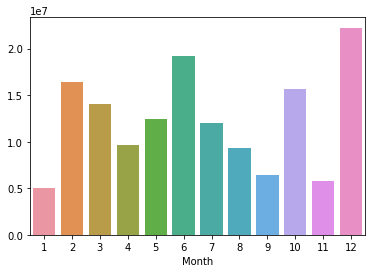

In [16]:
sales_month = data.groupby('Month')['Weekly_Sales'].agg('sum')
sns.barplot(x=sales_month.index, y=sales_month.values)


<AxesSubplot:xlabel='Month'>

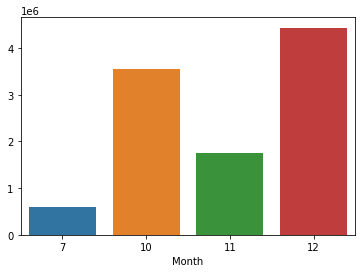

In [17]:
filter_holiday = data['Holiday_Flag'] == 1
data[filter_holiday]
sns.barplot(x=sales_per_month(data[filter_holiday]).index, y=sales_per_month(data[filter_holiday]).values)

It seems that there is a positive correlation between the holiday with the weekly sales

# 1. Checking for correlations

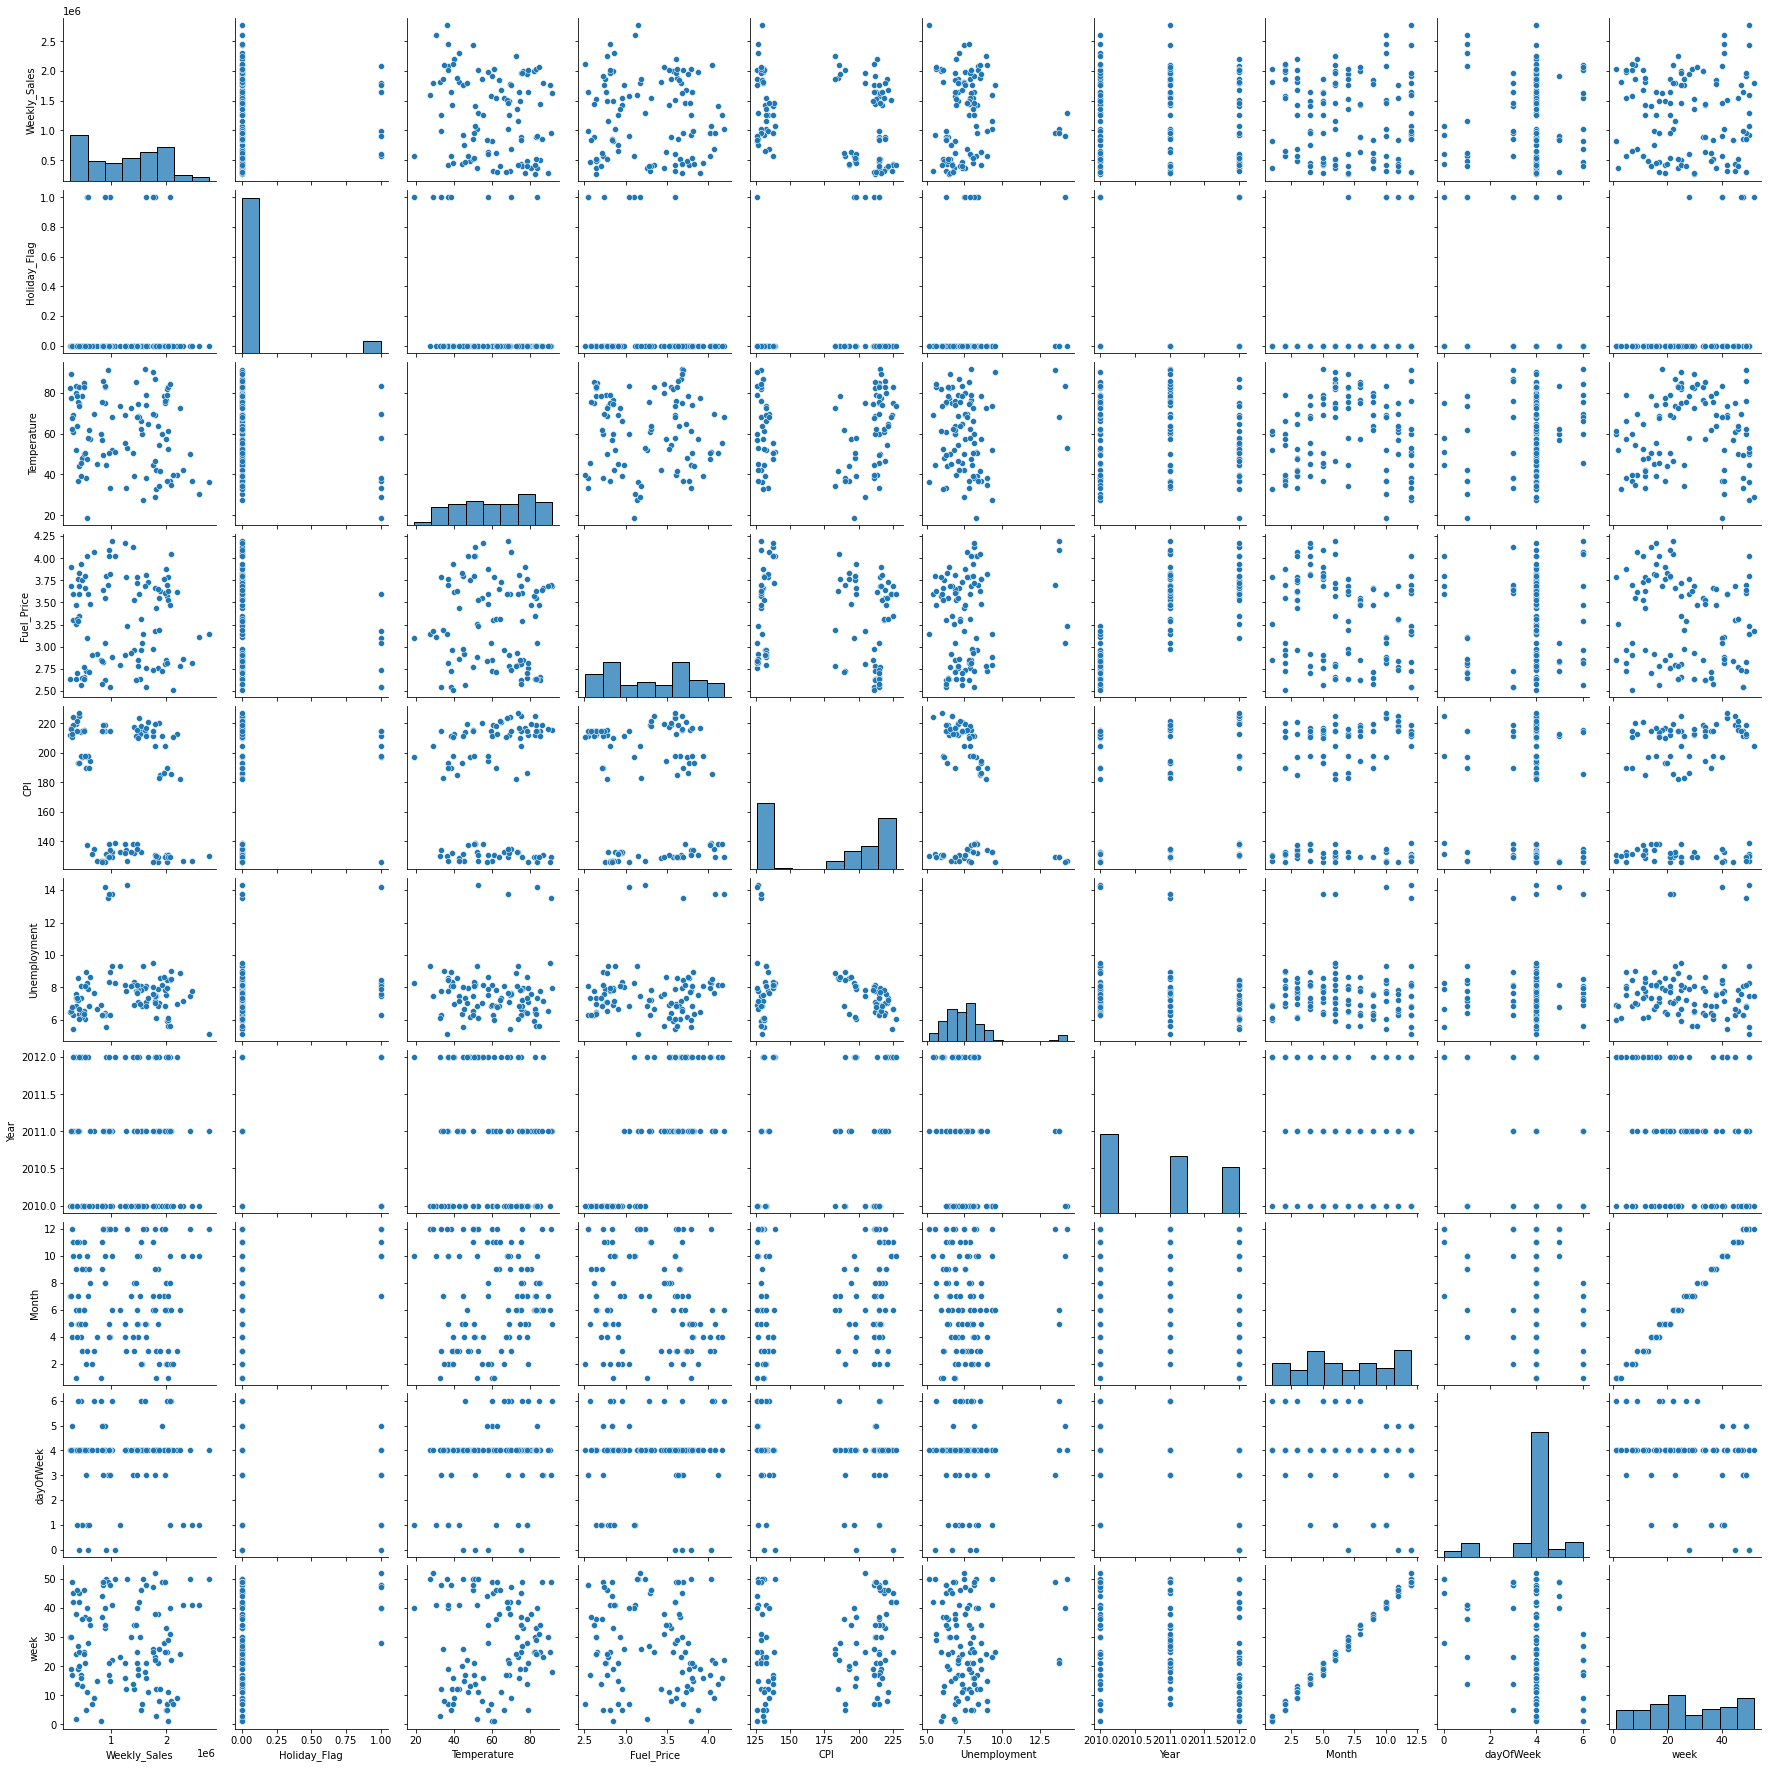

In [18]:
sns.pairplot(data=data)

At first glance to the heatmap and the graphs, there is no varible with strong correlation with Weekly_Sales

## Visualize distributions

In [ ]:
data.hist(figsize=(20,15))
plt.show()

## 2. Perform some cleaning

In [ ]:
# First, split the date according

In [ ]:
data_train, data_test = train_test_split(data, test_size=0.2)

In [ ]:
data_train.hist(figsize=(20,15))
plt.show()

After split, check the pourcentage of data per year

In [ ]:
# Original data
data['Year'].value_counts()*100/data.shape[0]

In [ ]:
print('Data instances per year')
data_train['Year'].value_counts()*100/data_train.shape[0]

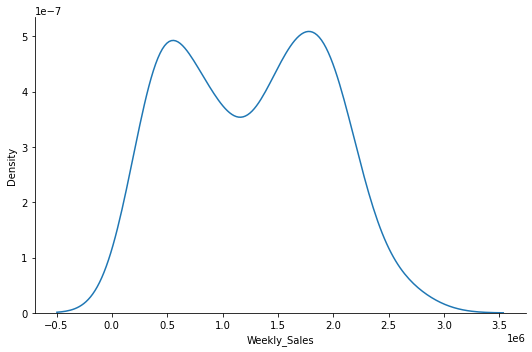

In [20]:
sns.displot(x='Weekly_Sales', kind='kde', data=data, aspect=1.5 )

In [ ]:
data.describe()